In [4]:
import numpy as np
import matplotlib.pyplot as plt
from model_base import get_default_params, NetworkModel
from experiments import get_null_ff_input_arrays
import ipywidgets as widgets
# %matplotlib ipympl
# plt.style.use('pretty')

In [5]:
N_cells, w_mean, conn_prob, bg_inputs, taus = get_default_params(flag_mean_pop=True)
wED = 0.7
model = NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=wED, flag_SOM_ad=False,
                     flag_w_hetero=False, flag_pre_inh=False)


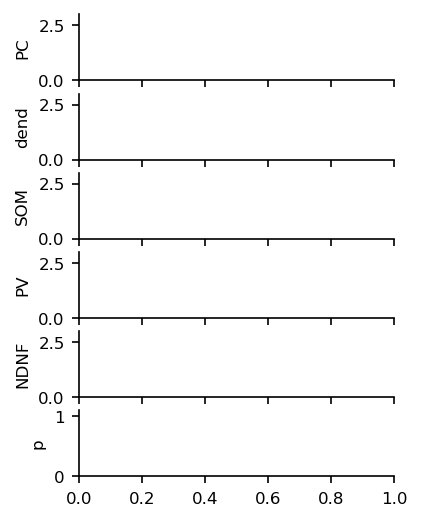

interactive(children=(FloatSlider(value=0.5, description='wPS', max=2.0), FloatSlider(value=1.0, description='…

In [6]:
# simulation parameters
dur = 1000
dt = 1
nt = int(dur/dt)
ts, te = 300, 500
I_activate = 1



fig1, ax1 = plt.subplots(6, 1, figsize=(3, 4), dpi=150, sharex=True, sharey='row', gridspec_kw={'left':0.2})
for i, label in enumerate(['PC', 'dend', 'SOM', 'PV', 'NDNF', 'p']):
    ax1[i].set(ylabel=label, ylim=[0, 3])
ax1[-1].set(ylim=[0,1.1])

@widgets.interact(wPS=(0, 2, 0.1), wEP=(0, 2, 0.1), wED=(0, 2, 0.1), wDS=(0, 2, 0.1), wDN=(0, 2, 0.1), wNS=(0, 2, 0.1),
                  wPN=(0, 2, 0.1), wSE=(0, 2, 0.1), wPE=(0, 2, 0.1),
                  xE=(0, 2, 0.1), xD=(0, 3, 0.1), xP=(0, 2, 0.1), xS=(0, 2, 0.1), xN=(0, 3, 0.1),
                  b=(0, 1, 0.1))
def update(wPS=0.5, wEP=1, wED=1, wDS=0.5, wDN=1.5, wPN=0.5, wNS=1, wSE=0.5, wPE=0.7,
           xE=1.3, xD=2.8, xP=1.5, xS=0.5, xN=2.2,
           b=0):
    
    for ii in range(6):
        [l.remove() for l in ax1[ii].lines]
    
    N_cells, w_mean, conn_prob, bg_inputs, taus = get_default_params(flag_mean_pop=True)
    
    p_init = 1-b*1
    
    w_mean['PS'] = wPS
    w_mean['EP'] = wEP
    w_mean['DS'] = wDS/p_init
    w_mean['PN'] = wPN
    w_mean['DN'] = wDN/p_init
    w_mean['NS'] = wNS/p_init
    w_mean['SE'] = wSE
    w_mean['PE'] = wPE
    w_mean['NN'], w_mean['PP'] = 0, 0 # no self-inhibition
    
    
    bg_inputs['E'] = xE
    bg_inputs['D'] = xD
    bg_inputs['S'] = xS
    bg_inputs['P'] = xP
    bg_inputs['N'] = xN
    
    print(wPS - wPN*wNS, wDN*wNS - wDS)
    
    model = NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=wED, flag_SOM_ad=False,
                         flag_w_hetero=False, flag_pre_inh=True, flag_with_VIP=False)
    model.b=b

    xFF = get_null_ff_input_arrays(nt, N_cells)
    xFF['S'][ts:te, :] = I_activate  # N_cells[cell]//2
    
    t, rE, rD, rS, rN, rP, rV, p, _, other = model.run(dur, xFF, dt=dt, p0=p_init)

    
    ax1[0].plot(t, rE, c='C3', alpha=1)
    ax1[1].plot(t, rD, c='darkred', alpha=1)
    ax1[2].plot(t, rS, c='C0', alpha=1)
    #     ax1[4].plot(t, rN, c='C1', alpha=0.5)
    ax1[3].plot(t, rP, c='darkblue', alpha=1)
    ax1[4].plot(t, rN, c='C1', alpha=1)
    ax1[5].plot(t, p, c='C2', alpha=1)
plt.show()


## Probe model with temporally varying inputs

#### First in reduced model of only NDNF, SOM and PC without recurrence


In [22]:
def set_sim_plot(xff_som, xff_ndnf, xff_dend, xff_soma, dur=1000, wDS=1, wDN=1, wNS=1, tauN=40, dt=1, pre_inh=True, b=0.5):

    N_cells, w_mean, conn_prob, bg_inputs, taus = get_default_params(flag_mean_pop=True)

    # set connections to zero to remove recurrence and self inhibition
    w_mean.update(SE=0, NN=0)

    # update weights with specified parameters
    w_mean.update(DS=wDS, DN=wDN, NS=wNS)

    # update time constants for slower NDNF and presynaptic inhibition
    taus.update(S=10, E=15, N=tauN)

    # set up model
    model = NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=1, flag_SOM_ad=False, flag_w_hetero=False,
                        flag_with_VIP=False, flag_with_PV=False, flag_pre_inh=pre_inh, taup=100, b=b)

    # simulation parameters
    nt = int(dur/dt)
    xFF = get_null_ff_input_arrays(nt, N_cells)
    xFF['S'][:, 0] = xff_som
    xFF['N'][:, 0] = xff_ndnf
    xFF['D'][:, 0] = xff_dend
    xFF['E'][:, 0] = xff_soma

    # run model
    t, rE, rD, rS, rN, rP, rV, p, cGABA, other = model.run(dur, xFF, dt=dt, p0=0.5, monitor_dend_inh=True)

    return dict(t=t, rE=rE, rD=rD, rS=rS, rN=rN, rP=rP, rV=rV, p=p, other=other)


def plot_rates(t, rE, rD, rS, rN, rP, rV, p, **kwargs):
    
    fig, ax = plt.subplots(5, 1, figsize=(4, 4), dpi=150, sharex=True, sharey='row', gridspec_kw={'left':0.2})
    ax[0].plot(t, rE, c='C3', alpha=1)
    ax[1].plot(t, rD, c='darkred', alpha=1)
    ax[2].plot(t, rS, c='C0', alpha=1)
    # ax[3].plot(t, rP, c='darkblue', alpha=1)
    ax[3].plot(t, rN, c='C1', alpha=1)
    ax[4].plot(t, p, c='C2', alpha=1)

    labelz = ['soma', 'dend', 'SOM', 'NDNF']
    for i, xx in enumerate(ax[:-1]):
        xx.set(ylim=(0, 2.5), ylabel=labelz[i])
    ax[4].set(ylim=(-0.05, 1.05), ylabel='p', xlabel='time (ms)')

def plot_rates2(t, rE, rD, rS, rN, rP, rV, p, **kwargs):
    
    fig, ax = plt.subplots(2, 1, figsize=(4, 2), dpi=150, sharex=True, sharey='row', gridspec_kw={'left':0.2})
    ax[0].plot(t, rE, c='C3', alpha=1)
    ax[0].plot(t, rD, c='darkred', alpha=1)
    ax[0].plot(t, rS, c='C0', alpha=1)
    # ax[3].plot(t, rP, c='darkblue', alpha=1)
    ax[0].plot(t, rN, c='C1', alpha=1)
    ax[1].plot(t, p, c='C2', alpha=1)

    # labelz = ['soma', 'dend', 'SOM', 'NDNF']
    for i, xx in enumerate(ax[:-1]):
        xx.set(ylim=(0, 3), ylabel='rate') #, ylabel=labelz[i])
    ax[-1].set(ylim=(-0.05, 1.05), ylabel='p', xlabel='time (ms)', yticks=[0, 1])




In [4]:
def make_sine(nt, freq):
    t = np.arange(nt)/1000
    return (np.sin(2*np.pi*freq*t)+1)/2

def make_box(nt, freq):
    t = np.arange(nt)/1000
    return (np.sign(np.sin(2*np.pi*freq*t))+1)/2

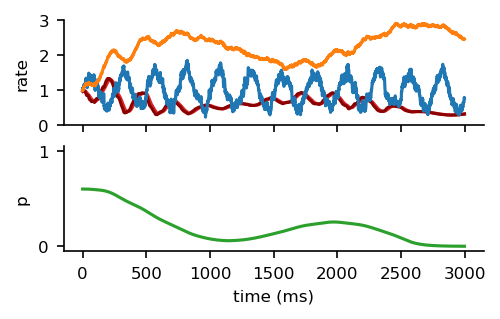

In [21]:
dur = 3000
dt = 1
nt = int(dur/dt)

pulse = np.zeros(nt)
plen = 100
pamp = 0.5
pulse[300:300+plen] = pamp
pulse[500:500+plen] = pamp
pulse[700:700+plen] = pamp

noise = np.random.normal(0, 0.5, size=nt)

ramp = np.zeros(nt)
ramp[500:1000] = np.linspace(0, 1, 500)

xff_som = make_sine(nt, 4)-0.5+noise
xff_ndnf = make_sine(nt, 0.5)-0.5+noise+0.5
xff_dend = np.zeros(nt)

# xff_ndnf = (make_box(nt, 5)-0.5)
# xff_som = (make_box(nt, 20)-0.5)

# xff_ndnf = np.zeros(nt)
# xff_som = np.zeros(nt)

# xff_ndnf[1000:1300] = 1.5
# xff_ndnf[2500:2700] = -1

# xff_som = make_box(nt, 5)-0.5
# xff_som[200:400] = 0.5

# xff_ndnf = np.zeros(nt)
# xff_ndnf[700:900] = 0.5


res = set_sim_plot(xff_som, xff_ndnf, xff_dend, xff_dend, tauN=50, dur=dur, wNS=1, wDN=1, wDS=1,
                   pre_inh=True, b=0.4)

# plot
plot_rates2(**res)

### Test if some frequencies are preferentially transmitted by SOM/NDNF

In [27]:
# first NDNF:

pre_inh = True
b = 0.3

freqs = np.array([0.5, 1, 2, 4, 8, 16])  # np.arange(1, 20)
amplitudes_n = np.zeros(len(freqs))
amplitudes_s = np.zeros(len(freqs))
amplitudes_n_for_s = np.zeros(len(freqs))

dur = 5000
dt = 1
nt = int(dur/dt)

# fig, ax = plt.subplots(2, 1, figsize=(3, 3), dpi=150)

for i, ff in enumerate(freqs):

    xff_null = np.zeros(nt)  
    xff_sine = make_sine(nt, ff)-0.5

    res_n = set_sim_plot(xff_null, xff_sine, xff_null, xff_null, tauN=50, dur=dur, wNS=0.5, wDN=1, wDS=1.,
                        pre_inh=pre_inh, b=b)

    res_s = set_sim_plot(xff_sine, xff_null, xff_null, xff_null, tauN=50, dur=dur, wNS=0.5, wDN=1, wDS=1.,
                        pre_inh=pre_inh, b=b)

    # ax[0].plot(res_n['t'], res_n['rD'])
    # ax[1].plot(res_s['t'], res_s['rD'])

    # Hacky way of computing response (max minus min after some initial time)
    amplitudes_n[i] = np.max(res_n['rD'][1000:])-np.min(res_n['rD'][1000:])
    amplitudes_s[i] = np.max(res_s['rD'][1000:])-np.min(res_s['rD'][1000:])
    # amplitudes_n[i] = np.max(res_n['other']['dend_inh_NDNF'][1000:])-np.min(res_n['other']['dend_inh_NDNF'][1000:])
    # amplitudes_s[i] = np.max(res_s['other']['dend_inh_SOM'][1000:])-np.min(res_s['other']['dend_inh_SOM'][1000:])
    amplitudes_n_for_s[i] = np.max(res_s['rN'][500:])-np.min(res_s['rN'][500:])

# plt.show()



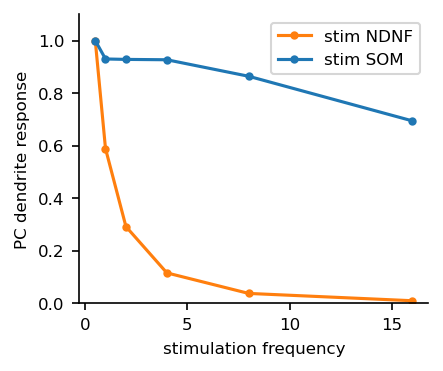

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2.5), dpi=150)

ax.plot(freqs, amplitudes_n/np.max(amplitudes_n), '.-', c='C1')
ax.plot(freqs, amplitudes_s/np.max(amplitudes_s), '.-', c='C0')
# ax.plot(freqs, amplitudes_n_for_s, '--', c='C0')

ax.set(xlabel='stimulation frequency', ylabel='PC dendrite response', ylim=[0, 1.1])
plt.legend(['stim NDNF', 'stim SOM'])

plt.show()

**Conclusion**
* NDNF interneurons best transmit low frequencies to PC dendrites (because of their slow timescale)
* SOM interneurons transmit intermediate frequencies
* this is because NDNFs are inhibit by SOMs and thus for low freuquencies provide disinhibition to PC dendrites that counterbalances the SOM inhibition
* the effect does not rely on presynaptic inhibition
* when NDNFs are as fast as SOMs, the effect is similar but the peak inhibition conveyed by SOMs  is lower and moves to higher frequencies
